## Rasterising the coastlines from 0.01mya to 0.60 mya

In [1]:
import os
from pycoalescence import Map
import seaborn as sb # for nice plotting
import matplotlib.pyplot as plt
from osgeo import gdal

In [2]:
# Change this path to wherever your shapefiles are
coastlines_input_dir = os.path.join("data", "shapefiles", "historical_coastlines")
coastlines_output_dir = os.path.join("data", "rasters", "historical_coastlines")
coastlines_output_compressed_dir = os.path.join("data", "rasters", "historical_coastlines_compressed")
# Define our input data
original_glacial = os.path.join("data", "rasters", "original", 
                                "0.01MYA_deBoer_global_1deg_icethickness_compressed.tif")
# projected_glacial = os.path.join("data", "rasters", "original",
#                                  "0.01MYA_deBoer_global_1deg_icethickness_compressed_reproj.tif")
glacial_dir = os.path.join("data", "rasters", "glacial")
for folder in [coastlines_output_dir, coastlines_output_compressed_dir, glacial_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
# Get the geotransform and projection of the glacial data (which we will try to match with the coastlines)
m_glacial = Map(original_glacial)
# Change the resolution below according to your needs
# (0.01 is 0.01 degrees resolution)
resolution = 0.1
orig_geotransform = m_glacial.get_geo_transform()
target_proj = m_glacial.get_projection()

In [4]:
# Create a separate reprojection for each band
m_glacial = Map(original_glacial)
for band_no in range(1, m_glacial.get_band_number()+1, 1):
    projected_glacial_tmp = os.path.join(glacial_dir, "{}.tif".format(band_no))
    m_glacial.data = None
    m_glacial.open(band_no=band_no)
    m_new = Map()
    m_new.data = m_glacial.data
    m_new.create(file=projected_glacial_tmp, 
                 geotransform=orig_geotransform, projection=target_proj)
    m_new.reproject_raster(x_scalar=resolution, y_scalar=resolution)
    target_geotransform = m_new.get_geo_transform()

In [6]:
# This performs the actual rasterisation
for file in os.listdir(coastlines_input_dir):
    coastline_shapefile = os.path.join(coastlines_input_dir, file)
    file_name, file_ext = os.path.splitext(coastline_shapefile)
    # Search for files which are .shp type
    if file_ext == ".shp":
        # Get the year (in mya) of the shapefile
        year = file.split("_", 1)[0].lower()
        # Define the name of our output raster
        coastline_raster = os.path.join(coastlines_output_dir, "{}.tif".format(year))
        coastline_raster_compressed = os.path.join(coastlines_output_compressed_dir, "{}_compressed.tif".format(year))
        if not os.path.exists(coastline_raster):
            m_coastline = Map()
            # perform the rasterisation
            m_coastline.rasterise(shape_file=coastline_shapefile, raster_file=coastline_raster, 
                                  output_srs=target_proj, geo_transform=target_geotransform,
                                  x_buffer=0, y_buffer=0, width=int(360/resolution), height=int(180/resolution), data_type=gdal.GDT_Byte)
        

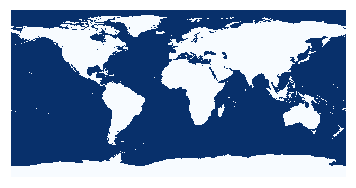

In [9]:
%matplotlib inline
m = Map(coastline_raster)
m.open()
sb.heatmap(m.data, cmap="Blues_r", square=True, vmin=0, vmax=1, yticklabels=False, xticklabels=False, cbar=False)